In [53]:
import sys, torch
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device chosen:", device)


Python: 3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]
Torch: 2.9.1
Device chosen: mps


In [54]:
# Imports and paths
import os, time, random
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Adjust these absolute paths if needed
PROC_IMG_DIR  = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/processed/images"
PROC_MASK_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/processed/masks"
CHECKPOINTS_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models"
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)


In [55]:
import albumentations as A

# ----------------------------------------------
# AUGMENTATION PIPELINE (SAFE FOR SATELLITE DATA)
# ----------------------------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),

    A.RandomRotate90(p=0.5),

    # Slight brightness/contrast change
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),

    # Small translation/shift (does not distort shape)
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.10,
        rotate_limit=20,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.5
    ),

    # Light noise to make model robust
    A.GaussNoise(var_limit=(5, 25), p=0.3),

    # Adding mild blur sometimes
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
])

# No augmentation for validation images
val_transform = A.Compose([])


In [56]:
class WaterDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))

        # Apply augmentation if available
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Normalize
        img = img.astype(np.float32) / 255.0
        mask = (mask > 0).astype(np.float32)

        # Convert to CHW format
        img = np.transpose(img, (2,0,1))
        mask = np.expand_dims(mask, axis=0)

        return torch.from_numpy(img), torch.from_numpy(mask)


In [57]:
# Load processed PNGs
all_imgs = sorted(glob(os.path.join(PROC_IMG_DIR, "*.png")))
all_masks = sorted(glob(os.path.join(PROC_MASK_DIR, "*.png")))
print("Found images:", len(all_imgs), "masks:", len(all_masks))

# Match names
imgs_dict = {os.path.basename(p): p for p in all_imgs}
masks_dict = {os.path.basename(p): p for p in all_masks}
common = sorted(set(imgs_dict.keys()).intersection(set(masks_dict.keys())))
imgs = [imgs_dict[k] for k in common]
masks = [masks_dict[k] for k in common]
print("Pairs:", len(imgs))

# Train/val split
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.2, random_state=42)
print("Train:", len(train_imgs), "Val:", len(val_imgs))


Found images: 41 masks: 41
Pairs: 41
Train: 32 Val: 9


img0.shape, mask0.shape: torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


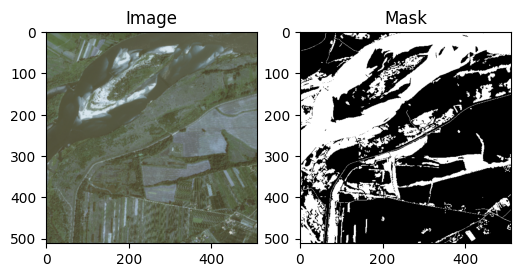

In [58]:
batch_size = 4    # change to 2 or 1 if you run out of memory
IMAGE_SIZE = 512  # model input used later (we assume processed images are 512x512)

train_ds = WaterDataset(train_imgs, train_masks, transform=train_transform)
val_ds   = WaterDataset(val_imgs,   val_masks,   transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

# quick sanity visualization
img0, mask0 = train_ds[0]
print("img0.shape, mask0.shape:", img0.shape, mask0.shape)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(np.transpose(img0.numpy(), (1,2,0))); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(mask0.squeeze().numpy(), cmap='gray'); plt.title("Mask")
plt.show()


In [59]:
import segmentation_models_pytorch as smp

# =============================
#   UNET with RESNET34 encoder
# =============================
model = smp.Unet(
    encoder_name="resnet34",       # Powerful pretrained backbone
    encoder_weights="imagenet",    # Transfer learning
    in_channels=3,                 # RGB
    classes=1,                     # Binary segmentation
    activation=None                # Use BCE+Dice (logits)
)

model = model.to(device)

print("Model created: UNet + ResNet34 encoder")
print("Total parameters:", sum(p.numel() for p in model.parameters())//1_000, "K")


Model created: UNet + ResNet34 encoder
Total parameters: 24436 K


In [60]:
# Better segmentation losses (SMP built-in)
dice_loss_fn = smp.losses.DiceLoss(mode="binary")
bce_loss_fn  = smp.losses.SoftBCEWithLogitsLoss()

def combined_loss(pred, target):
    return bce_loss_fn(pred, target) + dice_loss_fn(pred, target)

def iou_score(pred, target, thresh=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred) > thresh).float()
    inter = (pred * target).sum((1,2,3))
    union = ((pred + target) >= 1).float().sum((1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()


In [61]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

print("Model params:", sum(p.numel() for p in model.parameters())//1000, "K")


Model params: 24436 K


In [62]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(loader, desc="train"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def validate(model, loader, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="val"):
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            loss = combined_loss(preds, masks)
            running_loss += loss.item() * imgs.size(0)
            running_iou += iou_score(preds, masks)
    return running_loss / len(loader.dataset), running_iou / len(loader)


In [63]:
epochs = 12   # start modestly; increase after you verify
best_val_loss = float("inf")
history = {"train_loss":[], "val_loss":[], "val_iou":[]}

for epoch in range(1, epochs+1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_iou = validate(model, val_loader, device)
    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    print(f"Epoch {epoch}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_iou={val_iou:.4f} | {time.time()-t0:.1f}s")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        ckpt_path = os.path.join(CHECKPOINTS_DIR, "unet_best.pth")
        torch.save(model.state_dict(), ckpt_path)
        print("Saved best model ->", ckpt_path)


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/12 | train_loss=1.0692 | val_loss=474.4047 | val_iou=0.0017 | 14.1s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/12 | train_loss=0.8847 | val_loss=17.5029 | val_iou=0.0004 | 6.0s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/12 | train_loss=0.8468 | val_loss=20.2605 | val_iou=0.2516 | 5.7s


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/12 | train_loss=0.7764 | val_loss=1.2230 | val_iou=0.4914 | 5.8s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/12 | train_loss=0.8627 | val_loss=3.0112 | val_iou=0.5155 | 5.6s


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/12 | train_loss=0.7678 | val_loss=1.0171 | val_iou=0.5482 | 5.5s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/12 | train_loss=0.8376 | val_loss=0.9451 | val_iou=0.5803 | 5.5s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/12 | train_loss=0.7768 | val_loss=0.8860 | val_iou=0.5914 | 5.6s
Saved best model -> /Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/models/unet_best.pth


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/12 | train_loss=0.7631 | val_loss=1.2253 | val_iou=0.5683 | 6.5s


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/12 | train_loss=0.7117 | val_loss=0.9951 | val_iou=0.5991 | 5.6s


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/12 | train_loss=0.7473 | val_loss=1.0494 | val_iou=0.5475 | 5.5s


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/12 | train_loss=0.7393 | val_loss=0.9440 | val_iou=0.5560 | 5.5s


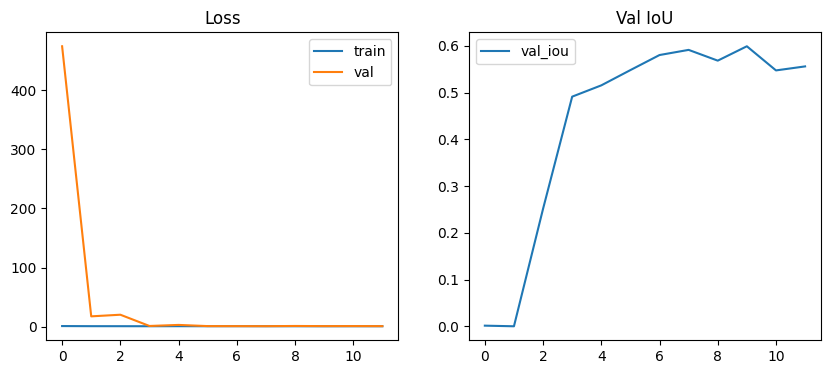

In [64]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history["val_iou"], label="val_iou")
plt.legend(); plt.title("Val IoU")
plt.show()


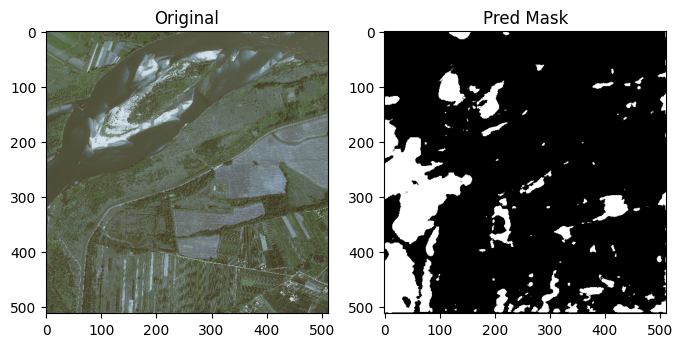

In [65]:
# load best and predict
ckpt_path = os.path.join(CHECKPOINTS_DIR, "unet_best.pth")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

def predict_image(img_path, show=True):
    img_orig = np.array(Image.open(img_path).convert("RGB"))
    img = cv2.resize(img_orig, (IMAGE_SIZE, IMAGE_SIZE))
    x = img.astype(np.float32)/255.0
    x = np.transpose(x, (2,0,1))[None,:,:,:]
    x = torch.from_numpy(x).to(device)
    with torch.no_grad():
        pred = model(x)
        pred = torch.sigmoid(pred).cpu().numpy()[0,0]
        mask = (pred > 0.5).astype(np.uint8)*255
    if show:
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img_orig); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title("Pred Mask")
        plt.show()
    return mask

# Example:
sample_img = train_imgs[0]
_ = predict_image(sample_img)


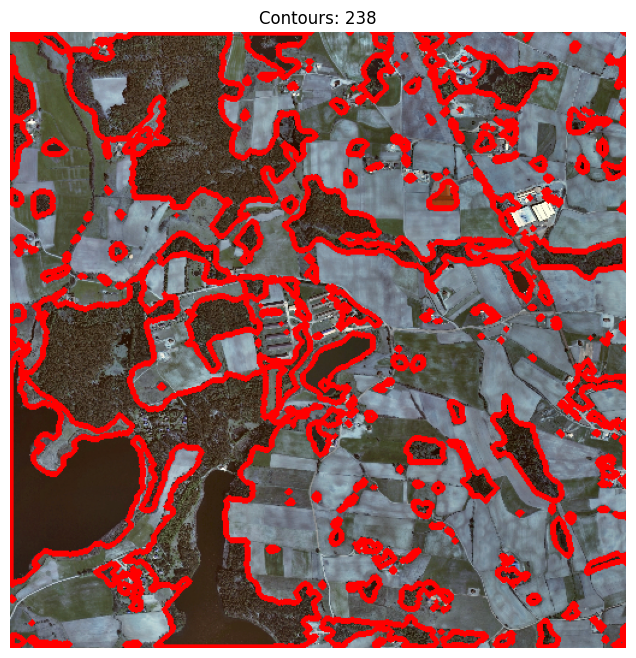

In [66]:
def overlay_contours(image_path, mask_512):
    img = cv2.imread(image_path)
    mask_resized = cv2.resize(mask_512, (img.shape[1], img.shape[0]))
    contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    cv2.drawContours(out, contours, -1, (0,0,255), 3)
    return out, contours

mask_pred = predict_image(train_imgs[1], show=False)  # 512x512 binary mask
overlay_img, contours = overlay_contours(train_imgs[1], mask_pred)
plt.figure(figsize=(8,8)); plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)); plt.title(f"Contours: {len(contours)}"); plt.axis('off')
plt.show()
